# Goal
Draw the likelihood of a GP model with a standard GPyTorch SE kernel and zero mean on a dataset.  
Then calculate approximations to the likelihood via MCMC, AIC, AICc, BIC and the Laplace approximation and draw their values on top of the actual likelihood to show how close/far they are from the true value.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import gpytorch
import torch
import stan
from itertools import product
import numpy as np
import copy

In [11]:
start = -10
end = 10
num_data = 100


train_x = torch.linspace(start, end, num_data)
train_y = torch.sin(0.5*3.1415*train_x)
#plt.plot(train_x, train_y)

In [12]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [13]:
def lik_log_prior(model, train_x, train_y, params):
    prior_dict = {"SE": {"raw_lengthscale": {"mean": 0.891, "std": 2.195}},
                    "PER": {"raw_lengthscale": {"mean": 0.338, "std": 2.636}, 
                            "raw_period_length": {"mean": 0.284, "std": 0.902}},
                    "LIN": {"raw_variance": {"mean": -1.463, "std": 1.633}},
                    "c": {"raw_outputscale": {"mean": -2.163, "std": 2.448}},
                    "noise": {"raw_noise": {"mean": -1.792, "std": 3.266}}}

    raw_lengthscale = {"mean": 0.891, "std": 2.195}
    raw_noise = {"mean": -1.792, "std": 3.266}

    output = model(train_x)
    loss = mll(output, train_y) *len(*model.train_inputs)
    mu_theta = torch.Tensor([0.891, -1.792])
    sigma_theta = torch.diag(torch.Tensor([2.195, 3.266]))
    prior = torch.distributions.MultivariateNormal(loc = mu_theta, covariance_matrix=sigma_theta)
    loss += prior.log_prob(params) 
    return loss

def laplace(params):
    param_opt = torch.Tensor([1.1111, -11.6667])
    hessian = torch.Tensor([[2.6359, 0.0204], [0.0204, 0.0036]])
    lap_dist = torch.distributions.MultivariateNormal(loc=param_opt, covariance_matrix=hessian.inverse())
    # params = [theta, noise]
    return torch.tensor(230.51)*torch.exp(-0.5*(params - param_opt).t()@hessian@(params - param_opt))
    #return lap_dist.log_prob(torch.Tensor(params))


In [14]:
# MLL
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
loss_list = list()
laplace_list = list()

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

length_range = torch.linspace(-0.5, 2, 100)
noise_range = torch.linspace(-40, 5, 100)
full_range = list(product(length_range, noise_range))
params_list = [p for p in model.parameters()]
max_mll = -100000
for theta, noise in full_range:
    # Set parameter value
    model.covar_module.raw_lengthscale.data = torch.Tensor([theta]) 
    model.likelihood.raw_noise.data = torch.Tensor([noise])
    # Output from model
    # Calc loss and backprop gradients
    loss = lik_log_prior(model, train_x, train_y, torch.Tensor([theta, noise]))
    loss_list.append(loss.item())
    laplace_list.append(laplace(torch.Tensor([theta, noise])))
    if loss.item() > max_mll and loss.item() > 0:
        max_mll = loss.item()
        #print(f"New max loss: {max_mll} at noise {noise} and l {theta}")
        best_parametrization = copy.deepcopy(model.state_dict())
        try:
            env_grads = torch.autograd.grad(loss, params_list, retain_graph=True, create_graph=True)
        except:
            import pdb
            pdb.set_trace()
        hess_params = []
        for i in range(len(env_grads)):
            hess_params.append(torch.autograd.grad(env_grads[i], params_list, retain_graph=True))
print(max_mll)
print(best_parametrization)
print(len(loss_list))

230.55776977539062
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-11.8182])), ('likelihood.noise_covar.raw_noise_constraint.lower_bound', tensor(1.0000e-04)), ('likelihood.noise_covar.raw_noise_constraint.upper_bound', tensor(inf)), ('covar_module.raw_lengthscale', tensor([1.1162])), ('covar_module.raw_lengthscale_constraint.lower_bound', tensor(0.)), ('covar_module.raw_lengthscale_constraint.upper_bound', tensor(inf))])
10000


In [15]:
# This one is taken from 18.04 version of the code
def Eigenvalue_correction_prior(hessian):
    vals, vecs = torch.linalg.eigh(hessian)
    k = len(vals)
    constructed_eigvals = torch.diag(torch.Tensor(
        [max(val, 1/(torch.exp(torch.tensor(2))*(6.283)**k)) for i, val in enumerate(vals)]))
    corrected_hessian = vecs@constructed_eigvals@vecs.t()
    return corrected_hessian, torch.diag(constructed_eigvals)


1.116161584854126

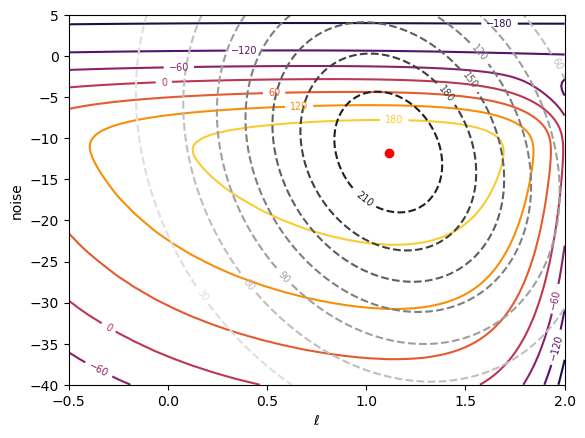

In [30]:
#plt.plot(param_range, loss_list)
from mpl_toolkits.mplot3d import axes3d
import numpy as np

loss_array = np.array(loss_list)
loss_array = np.reshape(loss_array, (100, 100))
loss_array = loss_array.T

laplace_array = np.array(laplace_list)
laplace_array = np.reshape(laplace_array, (100, 100))
laplace_array = laplace_array.T

#ax = plt.figure().add_subplot(projection='3d')
fig, ax = plt.subplots()
X, Y = np.meshgrid(length_range, noise_range)
Z = loss_array
ax.set_xlabel("$\ell$")
ax.set_ylabel("noise")

# Plot the 3D surface

A = ax.contour(X, Y, loss_array, cmap="inferno")
B = ax.contour(X, Y, laplace_array, cmap="binary", linestyles="dashed")
ax.clabel(A, inline=True, fontsize=7)
ax.clabel(B, inline=True, fontsize=7)
ax.plot(best_parametrization['covar_module.raw_lengthscale'].item(), best_parametrization['likelihood.noise_covar.raw_noise'].item(),
        marker="o", color="red")
#ax.plot_surface(X, Y, loss_array, lw=0.0, rstride=1, cstride=1,
#                alpha=0.3, cmap = "inferno")
#ax.plot_surface(X, Y, laplace_array, lw=0.0, rstride=1, cstride=1,
#                alpha=0.3, cmap = "binary")
#ax.plot(best_parametrization['covar_module.raw_lengthscale'].item(),
#best_parametrization['likelihood.noise_covar.raw_noise'].item(), max_mll, marker='.', markersize=5, color="black", alpha=1.0)

#ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Blues)



In [18]:
laplace_array

array([[ 0.6998813 ,  0.7899    ,  0.88999873, ..., 34.93518   ,
        33.49659   , 32.063293  ],
       [ 0.7438516 ,  0.83932877,  0.94547075, ..., 36.296143  ,
        34.79337   , 33.29679   ],
       [ 0.7899968 ,  0.8911886 ,  1.0036529 , ..., 37.682106  ,
        36.113495  , 34.552036  ],
       ...,
       [ 8.087496  ,  8.922721  ,  9.827668  , ..., 44.58728   ,
        41.79114   , 39.104565  ],
       [ 7.9972777 ,  8.821121  ,  9.7134905 , ..., 43.09975   ,
        40.387444  , 37.78226   ],
       [ 7.9021854 ,  8.714192  ,  9.593496  , ..., 41.630882  ,
        39.001873  , 36.47752   ]], dtype=float32)

In [19]:

best_parametrization['covar_module.raw_lengthscale'].item()
#best_parametrization['likelihood.noise_covar.raw_noise'].item()
#max_mll

1.116161584854126

In [20]:
model.load_state_dict(best_parametrization)
print(list(model.named_parameters()))
model.eval()
likelihood.eval()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-10, 10, 51)
    observed_pred = likelihood(model(test_x))
    

[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-11.8182], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([1.1162], requires_grad=True))]


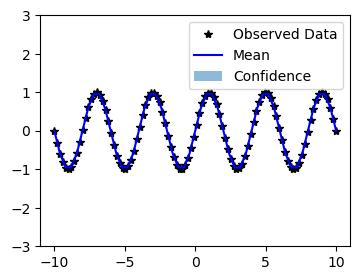

In [21]:

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])